In [1]:
import os
import pickle
import gymnasium as gym
import jax
import jax.numpy as jnp
import jax.nn as nn
import numpy as np
import optax
import matplotlib.pyplot as plt

from jax import grad, jit, lax, Array
from flax import linen
from typing import List, Tuple, Dict
from collections import namedtuple
from gymnasium import wrappers
from utils.common import KeyGenerator
%matplotlib inline 

In [2]:
class NeuralNet(linen.Module):
    hidden_size: int = 128
    action_space: int = 2

    @linen.compact
    def __call__(self, x) -> Tuple[jnp.ndarray, jnp.ndarray]:
        x = linen.Dense(self.hidden_size,
                        kernel_init=linen.initializers.xavier_normal())(x)
        x = linen.relu(x)
        logits = linen.Dense(
            self.action_space, kernel_init=linen.initializers.xavier_normal())(x)
        value = linen.Dense(
            1, kernel_init=linen.initializers.xavier_normal())(x)
        return logits, value

In [3]:
gamma = 0.99
lmda = 0.95
epsilon = 0.2
seed = 0
lr = 0.01

key_gen = KeyGenerator(seed)

env = gym.make('CartPole-v1')
print('observation shape:', env.observation_space.shape)
print('action shape:', env.action_space.shape)

neural_net = NeuralNet()
opt = optax.adam(lr)
Transition = namedtuple('Transition',
                        ['obs', 'act', 'rew', 'next_obs', 'terminated', 'logits'])
obs, info = env.reset(seed=seed)

# initialize the states
params = neural_net.init(key_gen()[0], obs)
opt_state = opt.init(params)


@jit
def policy(params: Dict, 
           obs: np.ndarray, 
           key: Array) -> Tuple[jnp.ndarray, jnp.ndarray]:
    '''
    Given the current state, return the action and the logits.
    '''
    logits, _ = neural_net.apply(params, obs)
    action = jax.random.categorical(key=key, logits=logits, axis=1)
    return action, logits


def unroll_policy(params: Dict,
                  T: int = 100) -> List[Transition]:
    '''
    Unroll the policy for T steps and return the trajectory as a list of transitions.
    '''
    trajectory = []
    obs, _ = env.reset()
    for _ in range(T):
        key = key_gen()[0]
        action, logits = policy(params, obs, key)
        action = np.asarray(action)
        logits = np.asarray(logits)
        next_obs, reward, terminated, truncated, _ = env.step(action)
        trajectory.append(Transition(obs, action, reward,
                          next_obs, terminated, logits))
        if truncated or terminated:
            obs, _ = env.reset()
        else:
            obs = next_obs
    return trajectory


def segment_to_batch(segment: List[Transition]) -> Dict[str, jnp.ndarray]:
    '''
    Convert a segment of transitions to a batch of transitions as a dictionary.
    '''
    obs = jnp.array([t.obs for t in segment])
    actions = jnp.array([t.act for t in segment])
    rewards = jnp.array([t.rew for t in segment])
    next_obs = jnp.array([t.next_obs for t in segment])
    terminated = jnp.array([t.terminated for t in segment], dtype=jnp.int8)
    logits = jnp.array([t.logits for t in segment])
    return dict(obs=obs, actions=actions, rewards=rewards, next_obs=next_obs, terminated=terminated, logits=logits)


def advantage_estimation(trajectory: List[Transition], params: Dict) -> jnp.ndarray:
    '''
    Given a trajectory, estimate the advantages using truncated GAE.
    '''
    obs = jnp.array([t.obs for t in trajectory])
    next_obs = jnp.array([t.next_obs for t in trajectory])
    rewards = jnp.array([t.rew for t in trajectory])
    terminated = jnp.array([t.terminated for t in trajectory], dtype=jnp.int8)

    _, values = neural_net.apply(params, obs)
    _, next_values = neural_net.apply(params, next_obs)
    values = jnp.squeeze(values)
    next_values = jnp.squeeze(next_values)
    T = len(trajectory)
    deltas = rewards + gamma * next_values * (1 - terminated) - values
    advantages = np.zeros(T)
    advantages[T-1] = deltas[T-1]
    for t in reversed(range(T-1)):
        advantages[t] = deltas[t] + gamma * lmda * \
            (1 - terminated[t]) * advantages[t + 1]
    return jnp.array(advantages)


def policy_loss(params: Dict,
                obs: jnp.ndarray,
                actions: jnp.ndarray,
                old_logits: jnp.ndarray,
                advantages: jnp.ndarray) -> np.ndarray:
    logits, _ = neural_net.apply(params, obs)
    new_log_probs = nn.log_softmax(logits, axis=1)
    old_log_probs = nn.log_softmax(old_logits, axis=1)
    indices = jnp.arange(len(actions))
    ratio = jnp.exp(new_log_probs[indices, actions] -
                    old_log_probs[indices, actions])
    clipped_ratio = jnp.clip(ratio, 1 - epsilon, 1 + epsilon)
    surrogate = jnp.minimum(ratio * advantages, clipped_ratio * advantages)
    return -jnp.mean(surrogate)


def value_loss(params: Dict,
               obs: jnp.ndarray,
               next_obs: jnp.ndarray,
               rewards: jnp.ndarray,
               terminated: jnp.ndarray) -> np.ndarray:
    _, values = neural_net.apply(params, obs)
    values = jnp.squeeze(values)
    _, next_values = lax.stop_gradient(neural_net.apply(params, next_obs))
    next_values = jnp.squeeze(next_values)
    tde = rewards + gamma * next_values * (1 - terminated) - values
    return jnp.mean(tde ** 2)


def ppo_loss(params: Dict,
             obs: jnp.ndarray,
             actions: jnp.ndarray,
             logits: jnp.ndarray,
             advantages: jnp.ndarray,
             next_obs: jnp.ndarray,
             rewards: jnp.ndarray,
             terminated: jnp.ndarray,
             loss_ratio: float = 0.5) -> jnp.ndarray:
    p_loss = policy_loss(params, obs, actions, logits, advantages)
    v_loss = value_loss(params, obs, next_obs, rewards, terminated)
    return p_loss + loss_ratio * v_loss

grad_func = grad(ppo_loss)

@jit
def update(params: Dict,
           opt_state: Dict,
           traj_segment: List[Transition],
           advantage_segment: jnp.ndarray) -> Tuple[Dict, Dict]:
    '''
    update the network weights and the optimizer state
    '''
    mini_batch = segment_to_batch(traj_segment)
    gradient = grad_func(params, advantages=advantage_segment, **mini_batch)
    updates, next_opt_state = opt.update(gradient, opt_state)
    next_params = optax.apply_updates(params, updates)
    return next_params, next_opt_state

def evaluate(params: Dict, num_eps=10):
    '''
    Evaluate the policy for num_eps episodes and return the average cumulative reward.
    '''
    env_eval = wrappers.RecordEpisodeStatistics(env)
    cum_rews = []
    for _ in range(num_eps):
        obs, info = env_eval.reset()
        terminated, truncated = False, False
        while not terminated and not truncated:
            key = key_gen()[0]
            act, _ = policy(params, obs, key)
            obs, _, terminated, truncated, info = env_eval.step(np.asarray(act))
        cum_rews.append(info['episode']['r'])
    return np.mean(cum_rews)

observation shape: (4,)
action shape: ()


step: 10, mean return: 91.5
step: 20, mean return: 109.19999694824219
step: 30, mean return: 232.5
step: 40, mean return: 69.80000305175781
step: 50, mean return: 281.70001220703125
step: 60, mean return: 239.0
step: 70, mean return: 489.79998779296875
step: 80, mean return: 131.6999969482422
step: 90, mean return: 500.0
step: 100, mean return: 500.0
step: 110, mean return: 500.0
step: 120, mean return: 500.0
step: 130, mean return: 500.0
step: 140, mean return: 500.0
step: 150, mean return: 500.0


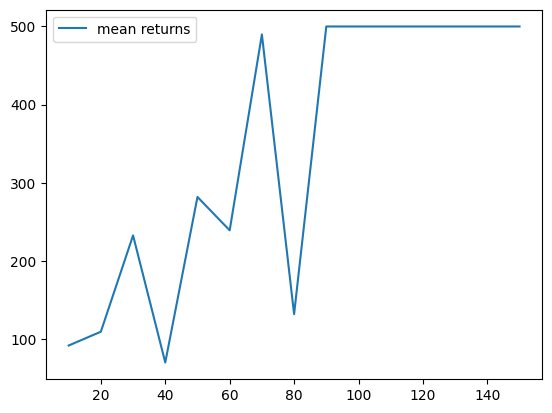

In [4]:
steps = 150 # number of training iterations
unroll_size = 1280 # number of steps to unroll the policy
mini_size = 128 # number of steps in each mini-batch
eval_freq = 10
best_params = params
best_mean_ret = 0
eval_steps = []
mean_returns = []

for step in range(1, steps + 1):
    traj = unroll_policy(params, T=unroll_size)
    advantage = advantage_estimation(traj, params)
    for i in range(0, unroll_size, mini_size):
        mini_traj = traj[i:i + mini_size]
        mini_adv = advantage[i:i + mini_size]
        params, opt_state = update(params, opt_state, mini_traj, mini_adv)

    if step % eval_freq == 0:
        mean_ret = evaluate(params)
        eval_steps.append(step)
        mean_returns.append(mean_ret)
        if mean_ret > best_mean_ret:
            best_mean_ret = mean_ret
            best_params = params
        print(f'step: {step}, mean return: {mean_ret}')
        ckpt = dict(best_params=best_params,
                    current_params=params,
                    opt_state=opt_state)
        ckpt_path = os.path.join('checkpoints', f'ckpt_{step}.pkl')
        with open(ckpt_path, 'wb') as f:
            pickle.dump(ckpt, f)

ckpt = dict(best_params=best_params,
            current_params=params,
            opt_state=opt_state)
ckpt_path = os.path.join('checkpoints', f'ckpt_last.pkl')
with open(ckpt_path, 'wb') as f:
    pickle.dump(ckpt, f)

plt.figure()
plt.plot(eval_steps, mean_returns, label='mean returns')
plt.legend()
env.close()

In [ ]:
# generate video
ckpt_path = os.path.join('checkpoints', f'ckpt_last.pkl')
with open(ckpt_path, 'rb') as f:
    ckpt = pickle.load(f)
params = ckpt['best_params']

test_env = gym.make('CartPole-v1', render_mode='rgb_array', max_episode_steps=500)
test_env = wrappers.RecordVideo(env=test_env, 
                                video_folder='./video',
                                name_prefix='PPO',
                                disable_logger=True)

obs, _ = test_env.reset(seed=42)
terminated, truncated = False, False
while not terminated and not truncated:
    key = key_gen()[0]
    action, _ = policy(params, obs, key)
    obs, rew, terminated, truncated, _ = test_env.step(np.asarray(action))
test_env.close()